# Driver Identification and Transport Mode Classification using ResNet50-GRU and BiLSTM MTL model
## (Hyperparam Tuning)
To better understand the code, check out `./prep_files/MultiTaskModel.ipynb`. That notebook explains the thought process behind this code on a sample dataset whilst this goes straight to the point. 

In [1]:
import numpy as np
import pandas as pd
import torch
from torchsummary import summary
from torch.utils.data import DataLoader, random_split, Subset

from src.engine import MTL_engine
from src.model_multitask import MultitaskModel
from src.plot import plot_history
from src.dataset import CombinedDataset
from src.hyperparam import RayTuning
from ray import tune, train

from IPython.display import display, HTML

In [2]:
# Load custom CSS file
css = HTML('<link rel="stylesheet" type="text/css" href="./custom.css">')  # Ensure the path is correct
display(css)

In [3]:
model = MultitaskModel(input_size=6, hidden_size=512, num_layers=2)
summary(model, verbose=0)

Layer (type:depth-idx)                   Param #
├─BiLSTMNetwork: 1-1                     --
|    └─LSTM: 2-1                         8,429,568
|    └─BatchNorm1d: 2-2                  2,048
├─ResNet50_GRU: 1-2                      --
|    └─Sequential: 2-3                   --
|    |    └─Conv2d: 3-1                  (9,408)
|    |    └─BatchNorm2d: 3-2             (128)
|    |    └─ReLU: 3-3                    --
|    |    └─MaxPool2d: 3-4               --
|    |    └─Sequential: 3-5              (215,808)
|    |    └─Sequential: 3-6              (1,219,584)
|    |    └─Sequential: 3-7              7,098,368
|    |    └─Sequential: 3-8              14,964,736
|    └─BatchNorm2d: 2-4                  4,096
|    └─Dropout: 2-5                      --
|    └─GRU: 2-6                          5,511,168
|    └─BatchNorm1d: 2-7                  1,024
├─Linear: 1-3                            786,944
├─BatchNorm1d: 1-4                       1,024
├─Dropout: 1-5                           --
├

In [4]:
model

MultitaskModel(
  (lstm_network): BiLSTMNetwork(
    (lstm): LSTM(6, 512, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
    (batch_norm): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (resnet_gru_network): ResNet50_GRU(
    (resnet50): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tr

In [5]:
from sklearn.utils.class_weight import compute_class_weight

import torch.nn as nn
import torch.optim as optim

#### Computing class weights for both tasks

driver identification

In [6]:
y_train = pd.read_csv('./data/feature_maps_labels/train/metadata.csv')
y_train = y_train.iloc[:,1].values
print('Classes:', np.unique(y_train))

class_weights_dr = torch.tensor(compute_class_weight('balanced', classes=np.unique(y_train), y=y_train), dtype=torch.float32)
class_weights_dr = class_weights_dr / class_weights_dr.sum()
class_weights_dr = class_weights_dr.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

print('Class weights:', class_weights_dr)
del y_train

Classes: [0 1 2 3]
Class weights: tensor([0.0153, 0.2646, 0.1717, 0.5485], device='cuda:0')


transport mode classification

In [7]:
y_train = pd.read_csv('./data/lstm_features_labels/train/metadata.csv')
y_train = y_train.iloc[:,1].values
print('Classes:', np.unique(y_train))

class_weights_tr = torch.tensor(compute_class_weight('balanced', classes=np.unique(y_train), y=y_train), dtype=torch.float32)
class_weights_tr = class_weights_tr / class_weights_tr.sum()
class_weights_tr = class_weights_tr.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

print('Class weights:', class_weights_tr)
del y_train

Classes: [0. 1. 2. 3. 4. 5. 6. 7.]
Class weights: tensor([0.0521, 0.0592, 0.4732, 0.1143, 0.0655, 0.1070, 0.0639, 0.0648],
       device='cuda:0')


In [8]:
lstm_base_dir = './data/lstm_features_labels/'
fmap_base_dir = './data/feature_maps_labels/'

train_datasets = CombinedDataset(fmap_base_dir, lstm_base_dir, mode='train', 
                                 rescale=False, augment=True)   #noRot augmentation
val_test_datasets = CombinedDataset(fmap_base_dir, lstm_base_dir, mode='valid',
                                 rescale=False, augment=True)   #noRot augmentation

np.random.seed(42)
valid_datasets, test_datasets = random_split(val_test_datasets, [0.5, 0.5])  

In [9]:
import random
np.random.seed(2)

train_datasets = Subset(train_datasets, random.sample(range(46240), 4624))
valid_datasets = Subset(valid_datasets, random.sample(range(5782), 578))
test_datasets = Subset(test_datasets, random.sample(range(5781), 578))

In [10]:
len(train_datasets), len(valid_datasets), len(test_datasets)

(4624, 578, 578)

### Hyperparameter Tuning

In [12]:
# Enhanced Hyperparameter search space for Multitask Model
config = {
    "optimizer": tune.choice(["adam", "adamw"]),
    "lr": tune.loguniform(1e-4, 1e-2),
    "scheduler": tune.choice(["exp", "ReduceLROnPlateau"]),
    "gamma": tune.uniform(0.3, 0.95),  # for exponential scheduler, wider range
    "patience": tune.choice([5, 10, 15]),  # for ReduceLROnPlateau
    "epochs": tune.choice([30]),  # Starting with a wider range
    "batch_size": tune.choice([32, 64, 128]),
    "weight_decay": tune.loguniform(1e-4, 0.1),  # Slightly wider range
    "hidden_size": tune.choice([256, 300, 512, 1024]),  # Including 300 and ranges around it
    "num_layers": tune.choice([1, 2, 3]),  # Number of GRU layers
    "dropout": tune.uniform(0.3, 0.7),  # Dropout rate, ensuring valid values for num_layers
    "alpha": tune.choice([1]),
    "beta": tune.choice([1])
}

criterion_driver = nn.CrossEntropyLoss(weight=class_weights_dr)
criterion_transport = nn.CrossEntropyLoss(weight=class_weights_tr)
criterion = [criterion_driver, criterion_transport]

save_dir = 'MultiTaskModel'
model = MultitaskModel
modelType = 'MultiTaskModel'
engine = MTL_engine

In [13]:
mytuner = RayTuning(config, save_dir, criterion, model, modelType, engine)

In [14]:
mytuner.main(train_datasets, valid_datasets, test_datasets, num_samples=40)

(train_model pid=28696) Checkpoint successfully created at: Checkpoint(filesystem=local, path=c:/Users/LEGION/Documents/Msc Data Science - Uni of Exeter/ECMM451 - Data Science Research Project (2023)/workspace/ray_results/MultiTaskModel/trial_89fac_00000/checkpoint_000000)
(train_model pid=28696) Checkpoint successfully created at: Checkpoint(filesystem=local, path=c:/Users/LEGION/Documents/Msc Data Science - Uni of Exeter/ECMM451 - Data Science Research Project (2023)/workspace/ray_results/MultiTaskModel/trial_89fac_00000/checkpoint_000001)
(train_model pid=28696) Checkpoint successfully created at: Checkpoint(filesystem=local, path=c:/Users/LEGION/Documents/Msc Data Science - Uni of Exeter/ECMM451 - Data Science Research Project (2023)/workspace/ray_results/MultiTaskModel/trial_89fac_00000/checkpoint_000002)
(train_model pid=28696) Checkpoint successfully created at: Checkpoint(filesystem=local, path=c:/Users/LEGION/Documents/Msc Data Science - Uni of Exeter/ECMM451 - Data Science Re

Best trial config: {'optimizer': 'adamw', 'lr': 0.0005392288692948486, 'scheduler': 'ReduceLROnPlateau', 'gamma': 0.7511991545263691, 'patience': 15, 'epochs': 30, 'batch_size': 128, 'weight_decay': 0.0422480267454383, 'hidden_size': 1024, 'num_layers': 1, 'dropout': 0.6409051706390204, 'alpha': 1, 'beta': 1}
Best trial final validation loss: 2.084122633934021
Best trial final validation accuracy: Driver77.3356%, Transport44.8097%


AttributeError: 'bool' object has no attribute 'sum'

Testing best config in this run

In [12]:
np.random.seed(42)

batch_size = 128
train_dl = DataLoader(train_datasets, batch_size, shuffle=True, num_workers=4)
valid_dl = DataLoader(valid_datasets, batch_size, shuffle=True, num_workers=4)
test_dl = DataLoader(test_datasets, batch_size, shuffle=False, num_workers=2)

In [17]:
criterion_driver = nn.CrossEntropyLoss(weight=class_weights_dr)
criterion_transport = nn.CrossEntropyLoss(weight=class_weights_tr)
model = MultitaskModel(input_size=6,hidden_size=1024, num_layers=1, dropout=0.6409051706390204)
optimizer = optim.AdamW(model.parameters(), lr=0.0005392288692948486, weight_decay=0.0422480267454383)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.13618183112843046, patience=15)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = model.to(device)

In [18]:
engine = MTL_engine(model, optimizer, scheduler, criterion_driver, criterion_transport, device)

In [19]:
hist = engine.train_validation(train_dl, valid_dl, epochs=30, save_path=None)

Epoch [1/30], Train Loss: 3.2986, Train Transport Acc: 17.08%, Train Driver Acc: 28.09%, Val Loss: 3.1645, Val Transport Acc: 12.80%, Val Driver Acc: 74.57%
Epoch [2/30], Train Loss: 2.9761, Train Transport Acc: 19.57%, Train Driver Acc: 58.28%, Val Loss: 2.7489, Val Transport Acc: 23.53%, Val Driver Acc: 59.00%
Epoch [3/30], Train Loss: 2.7209, Train Transport Acc: 24.46%, Train Driver Acc: 63.19%, Val Loss: 2.5555, Val Transport Acc: 29.41%, Val Driver Acc: 62.46%
Epoch [4/30], Train Loss: 2.6469, Train Transport Acc: 27.68%, Train Driver Acc: 67.86%, Val Loss: 2.7149, Val Transport Acc: 24.05%, Val Driver Acc: 75.26%
Epoch [5/30], Train Loss: 2.4051, Train Transport Acc: 31.29%, Train Driver Acc: 69.94%, Val Loss: 2.3064, Val Transport Acc: 29.41%, Val Driver Acc: 66.26%
Epoch [6/30], Train Loss: 2.1930, Train Transport Acc: 37.26%, Train Driver Acc: 70.37%, Val Loss: 2.4636, Val Transport Acc: 32.18%, Val Driver Acc: 72.15%
Epoch [7/30], Train Loss: 2.0731, Train Transport Acc: 37.

In [11]:
from src.plot import MTL_plot

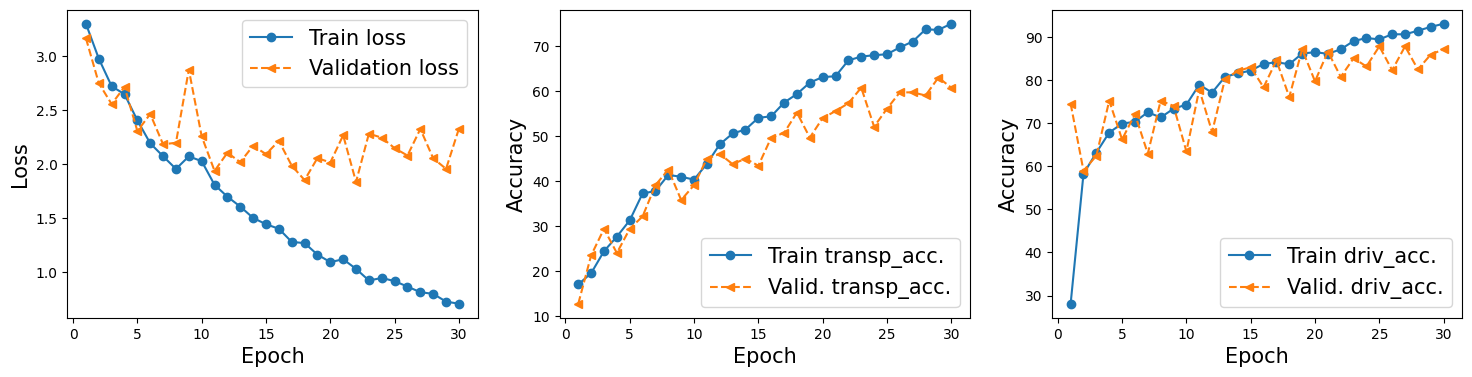

In [28]:
MTL_plot().plot_history(hist)

It seems like the transport side is attempting to learn while the driver id branch is overfitting or not even learning at all.

In [13]:
from MTL_modelTest import MultitaskModelX

In [15]:
criterion_driver = nn.CrossEntropyLoss(weight=class_weights_dr)
criterion_transport = nn.CrossEntropyLoss(weight=class_weights_tr)
model = MultitaskModelX(input_size=6,hidden_size=1024, num_layers=1, dropout=0.6409051706390204)
optimizer = optim.AdamW(model.parameters(), lr=0.0005392288692948486, weight_decay=0.0422480267454383)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.13618183112843046, patience=15)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = model.to(device)

In [16]:
engine = MTL_engine(model, optimizer, scheduler, criterion_driver, criterion_transport, device)

In [19]:
hist = engine.train_validation(train_dl, valid_dl, epochs=30, save_path=None)

Epoch [1/30], Train Loss: 2.4476, Train Transport Acc: 27.53%, Train Driver Acc: 69.25%, Val Loss: 2.6436, Val Transport Acc: 30.28%, Val Driver Acc: 69.55%
Epoch [2/30], Train Loss: 2.4746, Train Transport Acc: 28.91%, Train Driver Acc: 71.02%, Val Loss: 2.6429, Val Transport Acc: 24.74%, Val Driver Acc: 78.37%
Epoch [3/30], Train Loss: 2.2158, Train Transport Acc: 33.30%, Train Driver Acc: 73.83%, Val Loss: 2.9405, Val Transport Acc: 33.56%, Val Driver Acc: 70.76%
Epoch [4/30], Train Loss: 2.1215, Train Transport Acc: 36.55%, Train Driver Acc: 74.94%, Val Loss: 2.4194, Val Transport Acc: 36.68%, Val Driver Acc: 67.30%
Epoch [5/30], Train Loss: 1.9086, Train Transport Acc: 39.53%, Train Driver Acc: 78.55%, Val Loss: 2.7188, Val Transport Acc: 33.74%, Val Driver Acc: 78.55%
Epoch [6/30], Train Loss: 1.9375, Train Transport Acc: 40.03%, Train Driver Acc: 79.50%, Val Loss: 2.3694, Val Transport Acc: 38.93%, Val Driver Acc: 73.18%
Epoch [7/30], Train Loss: 1.7106, Train Transport Acc: 44.

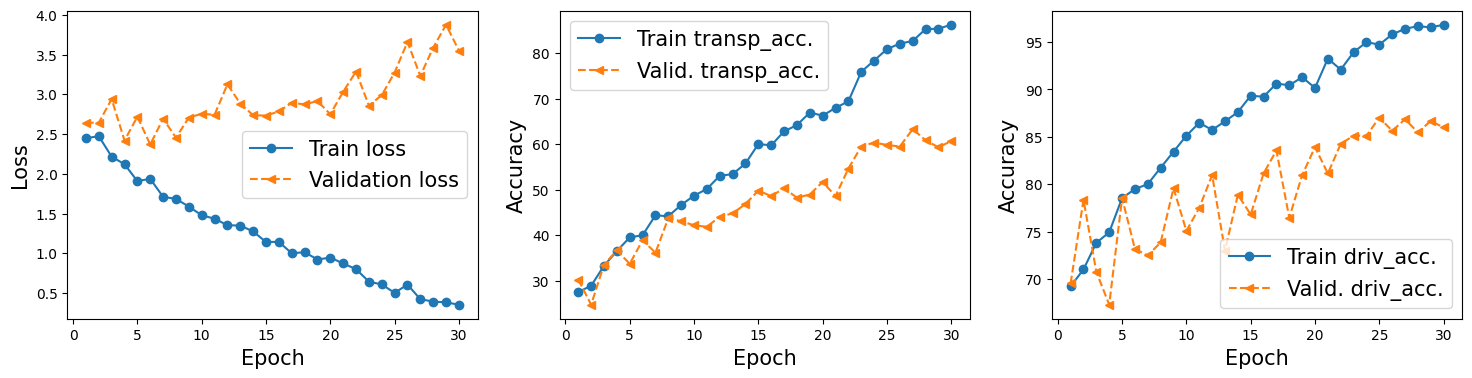

In [20]:
MTL_plot().plot_history(hist)

Let's try another model architecture since this start overfitting badly (this time batch normalization was added)

In [15]:
criterion_driver = nn.CrossEntropyLoss(weight=class_weights_dr)
criterion_transport = nn.CrossEntropyLoss(weight=class_weights_tr)
model = MultitaskModel(input_size=6,hidden_size=1024, num_layers=1, dropout=0.6409051706390204)
optimizer = optim.AdamW(model.parameters(), lr=0.0005392288692948486, weight_decay=0.0422480267454383)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.13618183112843046, patience=15)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = model.to(device)

In [16]:
engine = MTL_engine(model, optimizer, scheduler, criterion_driver, criterion_transport, device)

In [17]:
hist = engine.train_validation(train_dl, valid_dl, epochs=30, save_path=None)

Epoch [1/30], Train Loss: 3.0897, Train Transport Acc: 23.59%, Train Driver Acc: 30.21%, Val Loss: 3.4994, Val Transport Acc: 14.36%, Val Driver Acc: 12.80%
Epoch [2/30], Train Loss: 2.6978, Train Transport Acc: 28.20%, Train Driver Acc: 39.55%, Val Loss: 2.5761, Val Transport Acc: 30.10%, Val Driver Acc: 54.50%
Epoch [3/30], Train Loss: 2.4503, Train Transport Acc: 33.67%, Train Driver Acc: 63.91%, Val Loss: 2.4178, Val Transport Acc: 28.20%, Val Driver Acc: 75.09%
Epoch [4/30], Train Loss: 2.2250, Train Transport Acc: 35.66%, Train Driver Acc: 72.62%, Val Loss: 2.3348, Val Transport Acc: 31.83%, Val Driver Acc: 72.84%
Epoch [5/30], Train Loss: 2.1307, Train Transport Acc: 38.88%, Train Driver Acc: 71.52%, Val Loss: 2.4467, Val Transport Acc: 39.97%, Val Driver Acc: 72.49%
Epoch [6/30], Train Loss: 1.9870, Train Transport Acc: 41.72%, Train Driver Acc: 73.23%, Val Loss: 2.2636, Val Transport Acc: 41.87%, Val Driver Acc: 80.10%
Epoch [7/30], Train Loss: 1.9663, Train Transport Acc: 42.

In [18]:
from src.plot import MTL_plot

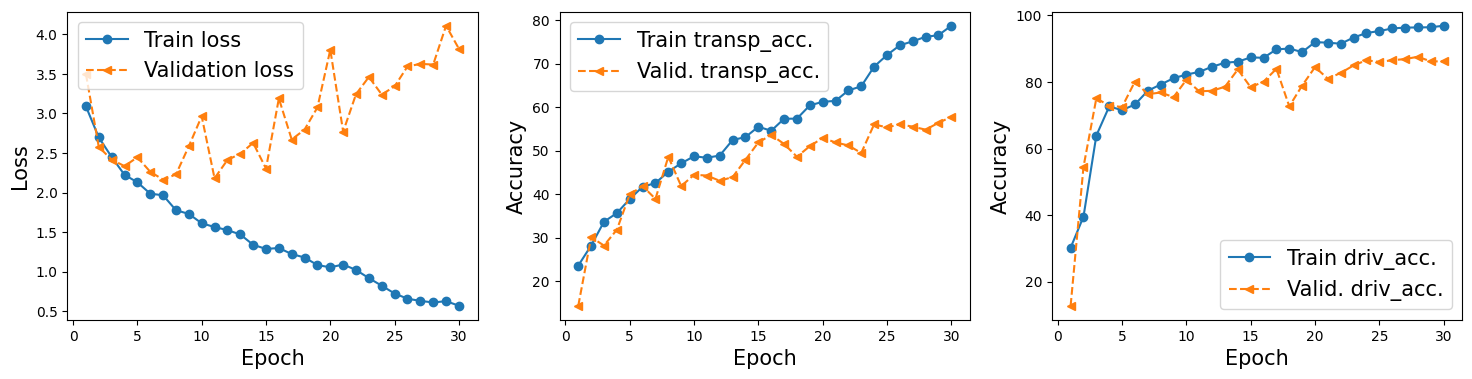

In [19]:
MTL_plot().plot_history(hist)

Let's run the tuner again but this time with batchnormalization and driver loss emphasized (beta)

In [20]:
# Enhanced Hyperparameter search space for Multitask Model
config = {
    "optimizer": tune.choice(["adam", "adamw"]),
    "lr": tune.loguniform(1e-4, 1e-2),
    "scheduler": tune.choice(["exp", "ReduceLROnPlateau"]),
    "gamma": tune.uniform(0.3, 0.95),  # for exponential scheduler, wider range
    "patience": tune.choice([5, 10, 15]),  # for ReduceLROnPlateau
    "epochs": tune.choice([20]),  # Starting with a wider range
    "batch_size": tune.choice([32, 64, 128]),
    "weight_decay": tune.loguniform(1e-4, 0.1),  # Slightly wider range
    "hidden_size": tune.choice([256, 300, 512, 1024]),  # Including 300 and ranges around it
    "num_layers": tune.choice([1, 2, 3]),  # Number of GRU layers
    "dropout": tune.uniform(0.3, 0.7),  # Dropout rate, ensuring valid values for num_layers
    "alpha": tune.choice([1]),
    "beta": tune.choice([2])
}

criterion_driver = nn.CrossEntropyLoss(weight=class_weights_dr)
criterion_transport = nn.CrossEntropyLoss(weight=class_weights_tr)
criterion = [criterion_driver, criterion_transport]

save_dir = 'MultiTaskModel'
model = MultitaskModel
modelType = 'MultiTaskModel'
engine = MTL_engine

In [21]:
mytuner = RayTuning(config, save_dir, criterion, model, modelType, engine)

In [22]:
mytuner.main(train_datasets, valid_datasets, test_datasets, num_samples=40)

(train_model pid=19876) Checkpoint successfully created at: Checkpoint(filesystem=local, path=c:/Users/LEGION/Documents/Msc Data Science - Uni of Exeter/ECMM451 - Data Science Research Project (2023)/workspace/ray_results/MultiTaskModel/trial_e5d6e_00000/checkpoint_000000)
(train_model pid=19876) Checkpoint successfully created at: Checkpoint(filesystem=local, path=c:/Users/LEGION/Documents/Msc Data Science - Uni of Exeter/ECMM451 - Data Science Research Project (2023)/workspace/ray_results/MultiTaskModel/trial_e5d6e_00000/checkpoint_000001)
(train_model pid=19876) Checkpoint successfully created at: Checkpoint(filesystem=local, path=c:/Users/LEGION/Documents/Msc Data Science - Uni of Exeter/ECMM451 - Data Science Research Project (2023)/workspace/ray_results/MultiTaskModel/trial_e5d6e_00000/checkpoint_000002)
(train_model pid=19876) Checkpoint successfully created at: Checkpoint(filesystem=local, path=c:/Users/LEGION/Documents/Msc Data Science - Uni of Exeter/ECMM451 - Data Science Re

Best trial config: {'optimizer': 'adamw', 'lr': 0.0001930783753654717, 'scheduler': 'exp', 'gamma': 0.3133799212922716, 'patience': 10, 'epochs': 20, 'batch_size': 64, 'weight_decay': 0.00043352817949515705, 'hidden_size': 1024, 'num_layers': 1, 'dropout': 0.5469926038510866, 'alpha': 1, 'beta': 2}
Best trial final validation loss: 2.941171669960022
Best trial final validation accuracy: Driver73.1834%, Transport34.4291%
   Test Loss: 3.3178, Test Transport Accuracy: 32.18%, Test Driver Accuracy: 70.07%
Best trial test set accuracy: Driver70.0692%, Transport32.1799%


Still getting horrible results overall. Let me add dropout layers to the shared fully connected layers.

In [13]:
criterion_driver = nn.CrossEntropyLoss(weight=class_weights_dr)
criterion_transport = nn.CrossEntropyLoss(weight=class_weights_tr)
model = MultitaskModel(input_size=6, hidden_size=1024, num_layers=1, dropout=0.6409051706390204)
optimizer = optim.AdamW(model.parameters(), lr=0.0005392288692948486, weight_decay=0.0422480267454383)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.13618183112843046, patience=15)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = model.to(device)

In [14]:
engine = MTL_engine(model, optimizer, scheduler, criterion_driver, criterion_transport, device)

In [15]:
hist = engine.train_validation(train_dl, valid_dl, epochs=30, save_path=None)

Epoch [1/30], Train Loss: 3.2634, Train Transport Acc: 19.33%, Train Driver Acc: 32.85%, Val Loss: 3.1153, Val Transport Acc: 23.88%, Val Driver Acc: 11.76%
Epoch [2/30], Train Loss: 3.0451, Train Transport Acc: 21.54%, Train Driver Acc: 29.22%, Val Loss: 3.0217, Val Transport Acc: 25.43%, Val Driver Acc: 31.83%
Epoch [3/30], Train Loss: 2.9048, Train Transport Acc: 22.49%, Train Driver Acc: 49.48%, Val Loss: 2.7536, Val Transport Acc: 28.37%, Val Driver Acc: 69.90%
Epoch [4/30], Train Loss: 2.6968, Train Transport Acc: 25.19%, Train Driver Acc: 67.45%, Val Loss: 2.6692, Val Transport Acc: 26.47%, Val Driver Acc: 64.88%
Epoch [5/30], Train Loss: 2.6319, Train Transport Acc: 26.02%, Train Driver Acc: 69.12%, Val Loss: 2.6068, Val Transport Acc: 29.76%, Val Driver Acc: 73.01%
Epoch [6/30], Train Loss: 2.5495, Train Transport Acc: 28.37%, Train Driver Acc: 72.73%, Val Loss: 2.5875, Val Transport Acc: 30.28%, Val Driver Acc: 78.20%
Epoch [7/30], Train Loss: 2.4433, Train Transport Acc: 30.

In [16]:
from src.plot import MTL_plot

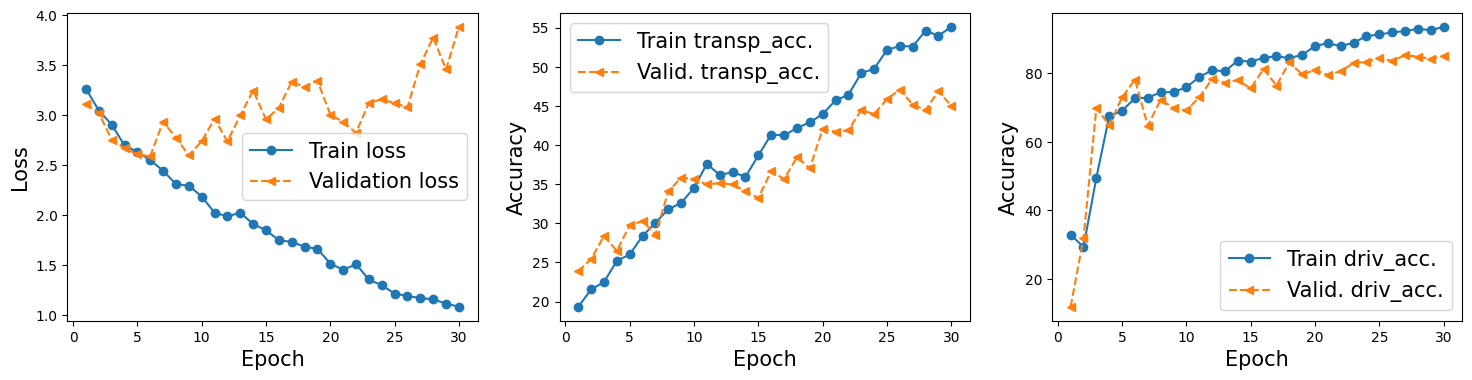

In [17]:
MTL_plot().plot_history(hist)